In [84]:
#Importing and uploading data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

bids = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/bids.csv')
train = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/train.csv')

#adding final time features created by subtracting bid time from the last time in the auction. 
test_df = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/final_times.csv')
test_df.columns = ['f_time']
bids = bids.merge(test_df, left_on='auction', right_index=True)
test_df = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/short_times.csv')
test_df.columns = ['short_time']
bids = bids.merge(test_df, left_on='bidder_id', right_index=True)
bids['diff_time'] = bids.f_time - bids.time
#create proper merge
groupfirst = bids.groupby(bids.bidder_id).nunique().sort_index()
mergedsecond = groupfirst.merge(train.sort_index(), left_index=True, right_index=True)

#now sort by desired values, update ranking and then split into bots and humans for plotting
mergedsecond = mergedsecond.sort_values(by=['auction'])
mergedsecond['ranking'] = np.arange(len(mergedsecond))
mergedsecond['bids_per_auction'] = mergedsecond.time/mergedsecond.auction
bots = mergedsecond[mergedsecond.outcome==1]
humans = mergedsecond[mergedsecond.outcome==0]


#mergefirst
mergedfirst = bids.merge(train, left_on='bidder_id', right_index=True)
groupedsecond = mergedfirst.groupby('bidder_id').nunique()

In [85]:
#Creating Train Test splits and pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

#X and y 
X = mergedsecond.drop(['outcome', 'payment_account', 'address', 'diff_time'], axis=1)
y = mergedsecond.outcome

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#oversampled set
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_sample(X_train, y_train)
#undersampled set
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_sample(X_train, y_train)


smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_sample(X_train, y_train)

In [86]:
len(X_train), len(y_train[y_train==1])

(1388, 75)

In [141]:
def roc_report(model_title, model, x_test, y_test):
    '''
    fit and plot different sampling techniques of a model against each other
    '''
    print("Classification report and ROC curves for model type: " + model_title)
    model.fit(X_ros, y_ros)
    y_pred = model.predict_proba(x_test)
    L = [x[1] for x in y_pred]
    report_ros = classification_report(y_test, model.predict(X_test))
    auc_ros  = roc_auc_score(y_test, L)
    fpr_ros = dict()
    tpr_ros = dict()
    roc_auc = dict()
    for i in range(2):
        fpr_ros[i], tpr_ros[i], _ = roc_curve(y_test, y_pred[:, i])
    
    
    model.fit(X_rus, y_rus)
    y_pred = model.predict_proba(x_test)
    L = [x[1] for x in y_pred]
    report_rus = classification_report(y_test, model.predict(X_test))
    auc_rus  = roc_auc_score(y_test, L)
    fpr_rus = dict()
    tpr_rus = dict()
    roc_auc = dict()
    for i in range(2):
        fpr_rus[i], tpr_rus[i], _ = roc_curve(y_test, y_pred[:, i])
        
        
    model.fit(X_smote, y_smote)
    y_pred = model.predict_proba(x_test)
    L = [x[1] for x in y_pred]
    report_smote = classification_report(y_test, model.predict(X_test))
    auc_smote  = roc_auc_score(y_test, L)
    fpr_smote = dict()
    tpr_smote = dict()
    roc_smote = dict()
    for i in range(2):
        fpr_smote[i], tpr_smote[i], _ = roc_curve(y_test, y_pred[:, i])
        
    f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)
    ax1.plot(fpr_ros[1],tpr_ros[1])
    ax1.set_title("Oversampled")
    ax2.plot(fpr_rus[1],tpr_rus[1])
    ax2.set_title("Undersampled")
    ax3.plot(fpr_smote[1],tpr_smote[1])
    ax3.set_title("SMOTE")
    plt.show()
    
    print("Oversampled AUC score: "+ str(auc_ros))
    print(report_ros)
    print("Undersampled AUC score: "+ str(auc_rus))
    print(report_rus)
    print("SMOTE AUC score: "+ str(auc_smote))
    print(report_smote)

Classification report and ROC curves for model type: Logistic Regression


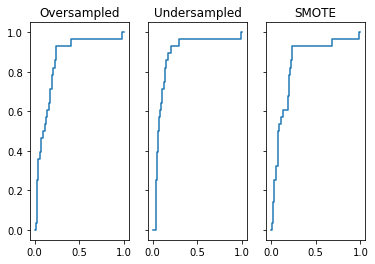

Oversampled AUC score: 0.85041498994
             precision    recall  f1-score   support

        0.0       0.99      0.77      0.87       568
        1.0       0.16      0.86      0.27        28

avg / total       0.95      0.78      0.84       596

Undersampled AUC score: 0.878961267606
             precision    recall  f1-score   support

        0.0       0.99      0.86      0.92       568
        1.0       0.21      0.79      0.34        28

avg / total       0.95      0.85      0.89       596

SMOTE AUC score: 0.836141851107
             precision    recall  f1-score   support

        0.0       0.99      0.78      0.87       568
        1.0       0.15      0.82      0.26        28

avg / total       0.95      0.78      0.84       596



In [142]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
roc_report("Logistic Regression", logreg, X_test, y_test)


Classification report and ROC curves for model type: Logistic Regression post gridsearch


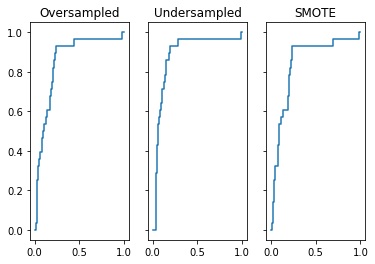

Oversampled AUC score: 0.848214285714
             precision    recall  f1-score   support

        0.0       0.99      0.77      0.87       568
        1.0       0.16      0.86      0.27        28

avg / total       0.95      0.78      0.84       596

Undersampled AUC score: 0.880030181087
             precision    recall  f1-score   support

        0.0       0.99      0.85      0.92       568
        1.0       0.22      0.86      0.35        28

avg / total       0.96      0.85      0.89       596

SMOTE AUC score: 0.835261569416
             precision    recall  f1-score   support

        0.0       0.99      0.78      0.87       568
        1.0       0.15      0.82      0.26        28

avg / total       0.95      0.78      0.84       596



In [143]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'intercept_scaling': [0.001, 0.01, 0.1, 1 , 10] }
log_cv = GridSearchCV(logreg, param_grid)
roc_report("Logistic Regression post gridsearch", log_cv, X_test, y_test)

Classification report and ROC curves for model type: Random Forest


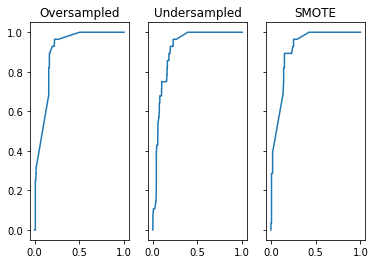

Oversampled AUC score: 0.902225855131
             precision    recall  f1-score   support

        0.0       1.00      0.78      0.87       568
        1.0       0.17      0.93      0.29        28

avg / total       0.96      0.79      0.85       596

Undersampled AUC score: 0.913135060362
             precision    recall  f1-score   support

        0.0       0.99      0.81      0.89       568
        1.0       0.19      0.89      0.31        28

avg / total       0.96      0.81      0.86       596

SMOTE AUC score: 0.913229376258
             precision    recall  f1-score   support

        0.0       0.99      0.80      0.88       568
        1.0       0.18      0.89      0.30        28

avg / total       0.96      0.80      0.86       596



In [146]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
roc_report("Random Forest", forest, X_test, y_test)

Classification report and ROC curves for model type: Random Forest post gridsearch


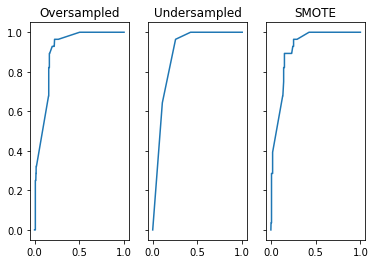

Oversampled AUC score: 0.902225855131
             precision    recall  f1-score   support

        0.0       1.00      0.78      0.87       568
        1.0       0.17      0.93      0.29        28

avg / total       0.96      0.79      0.85       596

Undersampled AUC score: 0.895089285714
             precision    recall  f1-score   support

        0.0       1.00      0.74      0.85       568
        1.0       0.16      0.96      0.27        28

avg / total       0.96      0.76      0.83       596

SMOTE AUC score: 0.913229376258
             precision    recall  f1-score   support

        0.0       0.99      0.80      0.88       568
        1.0       0.18      0.89      0.30        28

avg / total       0.96      0.80      0.86       596



In [145]:
param_grid = {'n_estimators': [1,2,3,4,5,6,7,8,9,10]}#, 'max_depth': [1,2,3,4,5] }
cv_forest = GridSearchCV(forest, param_grid)
roc_report("Random Forest post gridsearch", cv_forest, X_test, y_test)

Classification report and ROC curves for model type: Support Vectors


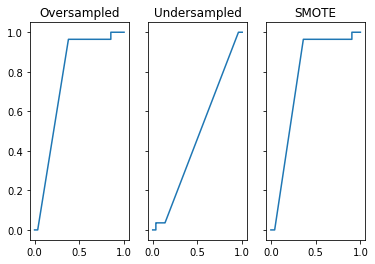

Oversampled AUC score: 0.770089285714
             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       568
        1.0       0.00      0.00      0.00        28

avg / total       0.91      0.94      0.92       596

Undersampled AUC score: 0.470762072435
             precision    recall  f1-score   support

        0.0       0.99      0.17      0.29       568
        1.0       0.05      0.96      0.10        28

avg / total       0.95      0.21      0.28       596

SMOTE AUC score: 0.772447183099
             precision    recall  f1-score   support

        0.0       1.00      0.42      0.59       568
        1.0       0.08      0.96      0.14        28

avg / total       0.95      0.45      0.57       596



In [147]:
from sklearn.svm import SVC
svc = SVC(probability=True)
roc_report("Support Vectors", svc, X_test, y_test)

Classification report and ROC curves for model type: Support Vectors post Gridsearch


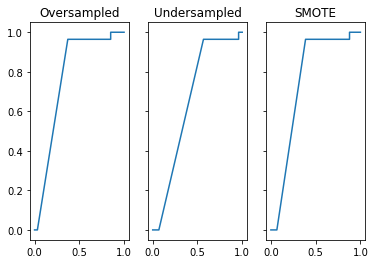

Oversampled AUC score: 0.775245221328
             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       568
        1.0       0.00      0.00      0.00        28

avg / total       0.91      0.93      0.92       596

Undersampled AUC score: 0.659299547284
             precision    recall  f1-score   support

        0.0       0.99      0.18      0.31       568
        1.0       0.05      0.96      0.10        28

avg / total       0.95      0.22      0.30       596

SMOTE AUC score: 0.749622736419
             precision    recall  f1-score   support

        0.0       1.00      0.42      0.59       568
        1.0       0.08      0.96      0.14        28

avg / total       0.95      0.44      0.57       596



In [155]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}#, 'degree': [1,2,3,4,5] }
cv_svc= GridSearchCV(svc, param_grid)
roc_report("Support Vectors post Gridsearch", cv_svc, X_test, y_test)

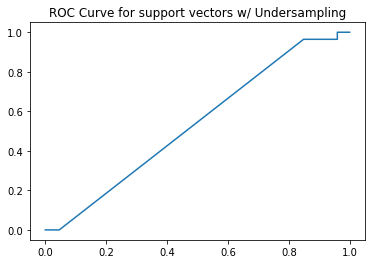

In [165]:
cv_svc.fit(X_rus, y_rus)
y_pred = cv_svc.predict_proba(X_test)
L = [x[1] for x in y_pred]
report_rus = classification_report(y_test, cv_svc.predict(X_test))
auc_rus  = roc_auc_score(y_test, L)
fpr_rus = dict()
tpr_rus = dict()
roc_auc = dict()
for i in range(2):
    fpr_rus[i], tpr_rus[i], _ = roc_curve(y_test, y_pred[:, i])
        
plt.plot(fpr_rus[1],tpr_rus[1], color='C0')
plt.title("ROC Curve for support vectors w/ Undersampling")
plt.show()

Classification report and ROC curves for model type: KNN Post Gridsearch


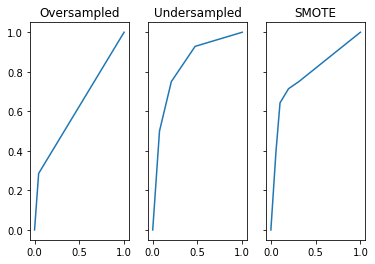

Oversampled AUC score: 0.619969818913
             precision    recall  f1-score   support

        0.0       0.96      0.95      0.96       568
        1.0       0.24      0.29      0.26        28

avg / total       0.93      0.92      0.93       596

Undersampled AUC score: 0.832180583501
             precision    recall  f1-score   support

        0.0       0.98      0.79      0.88       568
        1.0       0.15      0.75      0.25        28

avg / total       0.95      0.79      0.85       596

SMOTE AUC score: 0.785399899396
             precision    recall  f1-score   support

        0.0       0.98      0.90      0.94       568
        1.0       0.24      0.64      0.35        28

avg / total       0.95      0.89      0.91       596



In [149]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10] }
cv_knn= GridSearchCV(knn, param_grid)
roc_report("KNN Post Gridsearch", cv_knn, X_test, y_test)